In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lm_polygraph.ue_metrics.pred_rej_area import PredictionRejectionArea
from lm_polygraph.ue_metrics.ue_metric import (
    get_random_scores,
    normalize_metric,
)
import sklearn
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from collections import defaultdict
from sacrebleu import CHRF, BLEU
from utils import extract_and_prepare_data

In [ ]:
methods_dict = {
    'MaximumSequenceProbability': 'MSP',
    'Perplexity': 'PPL',
    'MeanTokenEntropy': 'MTE',
    'MonteCarloSequenceEntropy': 'MCSE',
    'MonteCarloNormalizedSequenceEntropy': 'MCNSE',
}

DATASETS = [
    'wmt14_csen',
    'wmt14_ruen',
]

all_metrics = ['Comet', 'BLEU']
all_methods =['MSP', 'PPL', 'MTE', 'MCSE', 'MCNSE']

### Plots for metrics 

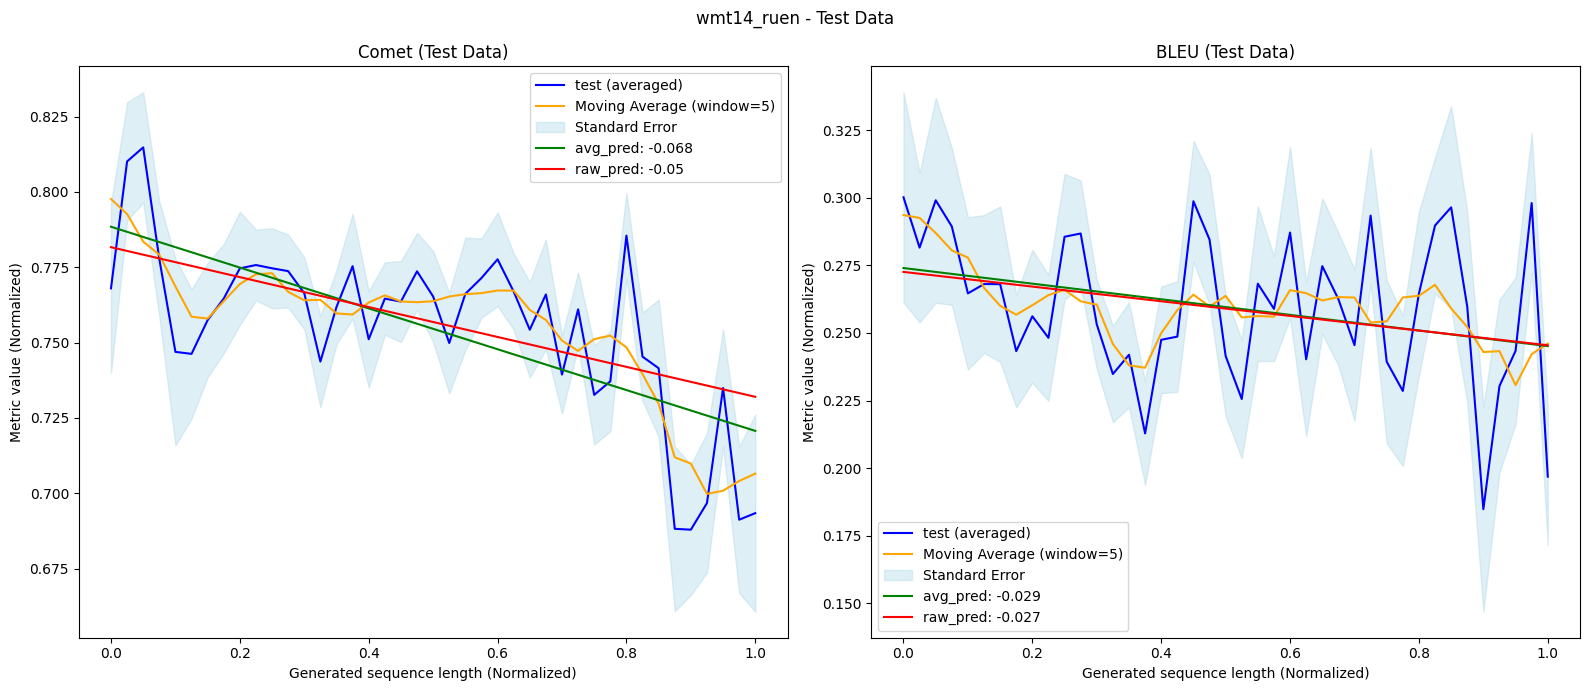

In [ ]:
from IPython.display import clear_output

for dataset in DATASETS:
    train_ue_values, \
    test_ue_values, \
    train_metric_values, \
    test_metric_values, \
    train_gen_lengths, \
    test_gen_lengths = extract_and_prepare_data(dataset, methods_dict, all_metrics, model='llama1b')

    upper_q = np.quantile(train_gen_lengths, 0.95)
    lower_q = np.quantile(train_gen_lengths, 0.05)
    below_q_ids = (train_gen_lengths < upper_q) & (train_gen_lengths > lower_q)
    train_gen_lengths = train_gen_lengths[below_q_ids]

    train_normalized_metric_values = {}
    test_normalized_metric_values = {}

    # Train Data Plot 
    fig, axs = plt.subplots(1, len(all_metrics), figsize=(8 * len(all_metrics), 7))
    
    for i, metric in enumerate(all_metrics):
        gen_length_scaler = MinMaxScaler()
        train_gen_lengths_normalized = gen_length_scaler.fit_transform(train_gen_lengths[:, np.newaxis]).squeeze()

        train_metric = train_metric_values[metric][below_q_ids]
        scaler = MinMaxScaler()
        train_normalized_metric_values[metric] = scaler.fit_transform(train_metric[:, np.newaxis]).squeeze()

        unique_lengths = np.unique(train_gen_lengths_normalized)
        avg_train_metric_values = []
        avg_train_gen_lengths_normalized = []

        std_errors = []
        for length in unique_lengths:
            idx = np.isclose(train_gen_lengths_normalized, length)
            std_error = np.std(train_normalized_metric_values[metric][idx]) / np.sqrt(len(train_normalized_metric_values[metric][idx]))
            std_errors.append(std_error)
            avg_train_metric_values.append(np.mean(train_normalized_metric_values[metric][idx]))
            avg_train_gen_lengths_normalized.append(length)

        std_errors = np.array(std_errors)

        avg_train_metric_values = np.array(avg_train_metric_values)
        avg_train_gen_lengths_normalized = np.array(avg_train_gen_lengths_normalized)

        # Compute moving average
        window_size = 5
        moving_avg = pd.Series(avg_train_metric_values).rolling(window=window_size, min_periods=1, center=True).mean()

        # Fit linear regression on averaged values
        train_linreg = sklearn.linear_model.LinearRegression()
        train_linreg.fit(avg_train_gen_lengths_normalized[:, np.newaxis], avg_train_metric_values)
        coef = train_linreg.coef_[0]

        # Fit linear regression on non-averaged data (raw data)
        raw_linreg = sklearn.linear_model.LinearRegression()
        raw_linreg.fit(train_gen_lengths_normalized[:, np.newaxis], train_normalized_metric_values[metric])

        ax = axs[i]
        ax.plot(avg_train_gen_lengths_normalized, avg_train_metric_values, label='train (averaged)', color='blue')
        ax.plot(avg_train_gen_lengths_normalized, moving_avg, label=f'Moving Average (window={window_size})', color='orange')
        ax.fill_between(avg_train_gen_lengths_normalized, avg_train_metric_values - std_errors, avg_train_metric_values + std_errors, color='lightblue', alpha=0.4, label='Standard Error')
        ax.plot(avg_train_gen_lengths_normalized, train_linreg.predict(avg_train_gen_lengths_normalized[:, np.newaxis]), label=f'avg_pred: {round(coef, 3)}', color='green')
        ax.plot(train_gen_lengths_normalized, raw_linreg.predict(train_gen_lengths_normalized[:, np.newaxis]), label=f'raw_pred: {round(raw_linreg.coef_[0], 3)}', color='red')

        ax.legend()
        ax.set_title(f'{metric} (Train Data)')
        ax.set_xlabel('Generated sequence length (Normalized)')
        ax.set_ylabel('Metric value (Normalized)')

    fig.suptitle(f'{dataset} - Train Data')
    plt.tight_layout()
    plt.savefig(f'metric_train_{dataset}.png')
    plt.show()


    upper_q_test = np.quantile(test_gen_lengths, 0.95)
    lower_q_test = np.quantile(test_gen_lengths, 0.05)
    below_q_ids_test = (test_gen_lengths < upper_q_test) & (test_gen_lengths > lower_q_test)
    test_gen_lengths = test_gen_lengths[below_q_ids_test]


    # Test Data Plot
    fig, axs = plt.subplots(1, len(all_metrics), figsize=(8 * len(all_metrics), 7))
    for i, metric in enumerate(all_metrics):
    # Normalize test sequence lengths using a separate MinMaxScaler for test data
        test_gen_length_scaler = MinMaxScaler()
        test_gen_lengths_normalized = test_gen_length_scaler.fit_transform(test_gen_lengths[:, np.newaxis]).squeeze()

        # Normalize test metrics using a new scaler for test data
        test_metric = test_metric_values[metric][below_q_ids_test]
        scaler_test = MinMaxScaler()
        test_normalized_metric_values[metric] = scaler_test.fit_transform(test_metric[:, np.newaxis]).squeeze()

        # Average values for each unique generated sequence length in the test data
        unique_lengths = np.unique(test_gen_lengths_normalized)
        avg_test_metric_values = []
        avg_test_gen_lengths_normalized = []

        std_errors_test = []
        for length in unique_lengths:
            idx = np.isclose(test_gen_lengths_normalized, length)
            std_error = np.std(test_normalized_metric_values[metric][idx]) / np.sqrt(len(test_normalized_metric_values[metric][idx]))
            std_errors_test.append(std_error)
            avg_test_metric_values.append(np.mean(test_normalized_metric_values[metric][idx]))
            avg_test_gen_lengths_normalized.append(length)

        std_errors_test = np.array(std_errors_test)

        avg_test_metric_values = np.array(avg_test_metric_values)
        avg_test_gen_lengths_normalized = np.array(avg_test_gen_lengths_normalized)

        # Compute moving average for test data
        moving_avg_test = pd.Series(avg_test_metric_values).rolling(window=window_size, min_periods=1, center=True).mean()

        # Fit linear regression on averaged values for test data
        test_linreg = sklearn.linear_model.LinearRegression()
        test_linreg.fit(avg_test_gen_lengths_normalized[:, np.newaxis], avg_test_metric_values)
        coef = test_linreg.coef_[0]

        # Fit linear regression on non-averaged (raw) test data
        raw_linreg_test = sklearn.linear_model.LinearRegression()
        raw_linreg_test.fit(test_gen_lengths_normalized[:, np.newaxis], test_normalized_metric_values[metric])

        ax = axs[i]
        ax.plot(avg_test_gen_lengths_normalized, avg_test_metric_values, label='test (averaged)', color='blue')
        ax.plot(avg_test_gen_lengths_normalized, moving_avg_test, label=f'Moving Average (window={window_size})', color='orange')
        ax.fill_between(avg_test_gen_lengths_normalized, avg_test_metric_values - std_errors_test, avg_test_metric_values + std_errors_test, color='lightblue', alpha=0.4, label='Standard Error')
        ax.plot(avg_test_gen_lengths_normalized, test_linreg.predict(avg_test_gen_lengths_normalized[:, np.newaxis]), label=f'avg_pred: {round(coef, 3)}', color='green')
        ax.plot(avg_test_gen_lengths_normalized, raw_linreg_test.predict(avg_test_gen_lengths_normalized[:, np.newaxis]), label=f'raw_pred: {round(raw_linreg_test.coef_[0], 3)}', color='red')

        ax.legend()
        ax.set_title(f'{metric} (Test Data)')
        ax.set_xlabel('Generated sequence length (Normalized)')
        ax.set_ylabel('Metric value (Normalized)')

    fig.suptitle(f'{dataset} - Test Data')
    plt.tight_layout()
    plt.savefig(f'metric_test_{dataset}.png')
    plt.show()


### Plots for metrics

In [ ]:
for dataset in DATASETS:
    train_ue_values, \
    test_ue_values, \
    train_metric_values, \
    test_metric_values, \
    train_gen_lengths, \
    test_gen_lengths = extract_and_prepare_data(dataset, methods_dict, all_metrics, model='llama1b')

    upper_q = np.quantile(train_gen_lengths, 0.95)
    lower_q = np.quantile(train_gen_lengths, 0.05)
    below_q_ids = (train_gen_lengths < upper_q) & (train_gen_lengths > lower_q)
    train_gen_lengths = train_gen_lengths[below_q_ids]

    train_normalized_metric_values = {}
    test_normalized_metric_values = {}
    all_methods = list(train_ue_values.keys())
    # Train Data Plot
    fig, axs = plt.subplots(1, len(all_methods), figsize=(8 * len(all_methods), 7))
    
    for i, metric in enumerate(all_methods):
        try:
            gen_length_scaler = MinMaxScaler()
            train_gen_lengths_normalized = gen_length_scaler.fit_transform(train_gen_lengths[:, np.newaxis]).squeeze()

            # Normalize train metrics
            train_metric = train_ue_values[metric][below_q_ids]
            scaler = MinMaxScaler()
            train_normalized_metric_values[metric] = scaler.fit_transform(train_metric[:, np.newaxis]).squeeze()

            # Average values for each unique generated sequence length
            unique_lengths = np.unique(train_gen_lengths_normalized)
            avg_train_metric_values = []
            avg_train_gen_lengths_normalized = []

            std_errors = []
            for length in unique_lengths:
                idx = np.isclose(train_gen_lengths_normalized, length)
                std_error = np.std(train_normalized_metric_values[metric][idx]) / np.sqrt(len(train_normalized_metric_values[metric][idx]))
                std_errors.append(std_error)
                avg_train_metric_values.append(np.mean(train_normalized_metric_values[metric][idx]))
                avg_train_gen_lengths_normalized.append(length)

            std_errors = np.array(std_errors)

            avg_train_metric_values = np.array(avg_train_metric_values)
            avg_train_gen_lengths_normalized = np.array(avg_train_gen_lengths_normalized)

            # Compute moving average
            window_size = 5
            moving_avg = pd.Series(avg_train_metric_values).rolling(window=window_size, min_periods=1, center=True).mean()

            # Fit linear regression on averaged values
            train_linreg = sklearn.linear_model.LinearRegression()
            train_linreg.fit(avg_train_gen_lengths_normalized[:, np.newaxis], avg_train_metric_values)
            coef = train_linreg.coef_[0]

            # Fit linear regression on non-averaged data (raw data)
            raw_linreg = sklearn.linear_model.LinearRegression()
            raw_linreg.fit(train_gen_lengths_normalized[:, np.newaxis], train_normalized_metric_values[metric])

            ax = axs[i]
            ax.plot(avg_train_gen_lengths_normalized, avg_train_metric_values, label='train (averaged)', color='blue')
            ax.plot(avg_train_gen_lengths_normalized, moving_avg, label=f'Moving Average (window={window_size})', color='orange')
            ax.fill_between(avg_train_gen_lengths_normalized, avg_train_metric_values - std_errors, avg_train_metric_values + std_errors, color='lightblue', alpha=0.4, label='Standard Error')
            ax.plot(avg_train_gen_lengths_normalized, train_linreg.predict(avg_train_gen_lengths_normalized[:, np.newaxis]), label=f'avg_pred: {round(coef, 3)}', color='green')
            ax.plot(train_gen_lengths_normalized, raw_linreg.predict(train_gen_lengths_normalized[:, np.newaxis]), label=f'raw_pred: {round(raw_linreg.coef_[0], 3)}', color='red')

            ax.legend()
            ax.set_title(f'{metric} (Train Data)')
            ax.set_xlabel('Generated sequence length (Normalized)')
            ax.set_ylabel('Metric value (Normalized)')
        except Exception as ex:
            print(f"Exception: {ex}\n values: {len(train_ue_values[metric])} , lengths: {len(train_gen_lengths)}")

    fig.suptitle(f'{dataset} - Train Data')
    plt.tight_layout()
    plt.savefig(f'UE_train_{dataset}.png')
    plt.show()

    upper_q_test = np.quantile(test_gen_lengths, 0.95)
    lower_q_test = np.quantile(test_gen_lengths, 0.05)
    below_q_ids_test = (test_gen_lengths < upper_q_test) & (test_gen_lengths > lower_q_test)
    test_gen_lengths = test_gen_lengths[below_q_ids_test]


    # Test Data Plot (Separate figure)
    fig, axs = plt.subplots(1, len(all_methods), figsize=(8 * len(all_methods), 7))
    for i, metric in enumerate(all_methods):
    # Normalize test sequence lengths using a separate MinMaxScaler for test data
        test_gen_length_scaler = MinMaxScaler()
        test_gen_lengths_normalized = test_gen_length_scaler.fit_transform(test_gen_lengths[:, np.newaxis]).squeeze()

        # Normalize test metrics using a new scaler for test data
        test_metric = test_ue_values[metric][below_q_ids_test]
        scaler_test = MinMaxScaler()
        test_normalized_metric_values[metric] = scaler_test.fit_transform(test_metric[:, np.newaxis]).squeeze()

        # Average values for each unique generated sequence length in the test data
        unique_lengths = np.unique(test_gen_lengths_normalized)
        avg_test_metric_values = []
        avg_test_gen_lengths_normalized = []

        std_errors_test = []
        for length in unique_lengths:
            idx = np.isclose(test_gen_lengths_normalized, length)
            std_error = np.std(test_normalized_metric_values[metric][idx]) / np.sqrt(len(test_normalized_metric_values[metric][idx]))
            std_errors_test.append(std_error)
            avg_test_metric_values.append(np.mean(test_normalized_metric_values[metric][idx]))
            avg_test_gen_lengths_normalized.append(length)

        std_errors_test = np.array(std_errors_test)

        avg_test_metric_values = np.array(avg_test_metric_values)
        avg_test_gen_lengths_normalized = np.array(avg_test_gen_lengths_normalized)

        # Compute moving average for test data
        moving_avg_test = pd.Series(avg_test_metric_values).rolling(window=window_size, min_periods=1, center=True).mean()

        # Fit linear regression on averaged values for test data
        test_linreg = sklearn.linear_model.LinearRegression()
        test_linreg.fit(avg_test_gen_lengths_normalized[:, np.newaxis], avg_test_metric_values)
        coef = test_linreg.coef_[0]

        # Fit linear regression on non-averaged (raw) test data
        raw_linreg_test = sklearn.linear_model.LinearRegression()
        raw_linreg_test.fit(test_gen_lengths_normalized[:, np.newaxis], test_normalized_metric_values[metric])

        ax = axs[i]
        ax.plot(avg_test_gen_lengths_normalized, avg_test_metric_values, label='test (averaged)', color='blue')
        ax.fill_between(avg_test_gen_lengths_normalized, avg_test_metric_values - std_errors_test, avg_test_metric_values + std_errors_test, color='lightblue', alpha=0.4, label='Standard Error')
        ax.plot(avg_test_gen_lengths_normalized, moving_avg_test, label=f'Moving Average (window={window_size})', color='orange')
        ax.plot(avg_test_gen_lengths_normalized, test_linreg.predict(avg_test_gen_lengths_normalized[:, np.newaxis]), label=f'avg_pred: {round(coef, 3)}', color='green')
        ax.plot(avg_test_gen_lengths_normalized, raw_linreg_test.predict(avg_test_gen_lengths_normalized[:, np.newaxis]), label=f'raw_pred: {round(raw_linreg_test.coef_[0], 3)}', color='red')

        ax.legend()
        ax.set_title(f'{metric} (Test Data)')
        ax.set_xlabel('Generated sequence length (Normalized)')
        ax.set_ylabel('Metric value (Normalized)')

    fig.suptitle(f'{dataset} - Test Data')
    plt.tight_layout()
    plt.savefig(f'UE_test_{dataset}.png')
    plt.show()



### P-value analysis

In [ ]:
import numpy as np
import sklearn.linear_model
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import t
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

coefficients = []  # List to store x1 coefficient results
coefficients_test = []
for dataset in DATASETS:
    train_ue_values, \
    test_ue_values, \
    train_metric_values, \
    test_metric_values, \
    train_gen_lengths, \
    test_gen_lengths = extract_and_prepare_data(dataset, methods_dict, all_metrics, model='llama1b')

    # Filter based on quantiles for train and test separately
    upper_q_train = np.quantile(train_gen_lengths, 0.95)
    lower_q_train = np.quantile(train_gen_lengths, 0.05)
    below_q_train = (train_gen_lengths < upper_q_train) & (train_gen_lengths > lower_q_train)
    train_gen_lengths = train_gen_lengths[below_q_train]

    upper_q_test = np.quantile(test_gen_lengths, 0.95)
    lower_q_test = np.quantile(test_gen_lengths, 0.05)
    below_q_test = (test_gen_lengths < upper_q_test) & (test_gen_lengths > lower_q_test)
    test_gen_lengths = test_gen_lengths[below_q_test]

    dataset_results = {}

    for metric in all_metrics:  # Iterate over actual metric names
        try:
            # Normalize sequence lengths
            gen_length_scaler_train = MinMaxScaler()
            train_gen_lengths_normalized = gen_length_scaler_train.fit_transform(train_gen_lengths[:, np.newaxis]).squeeze()

            gen_length_scaler_test = MinMaxScaler()
            test_gen_lengths_normalized = gen_length_scaler_test.fit_transform(test_gen_lengths[:, np.newaxis]).squeeze()

            # Normalize metric values
            train_metric = train_metric_values[metric][below_q_train]
            scaler_train = MinMaxScaler()
            train_normalized_metric_values = scaler_train.fit_transform(train_metric[:, np.newaxis]).squeeze()

            test_metric = test_metric_values[metric][below_q_test]
            scaler_test = MinMaxScaler()
            test_normalized_metric_values = scaler_test.fit_transform(test_metric[:, np.newaxis]).squeeze()
            X = train_gen_lengths_normalized
            y = train_normalized_metric_values

            X2 = sm.add_constant(X)

            # Fit the OLS model
            est = sm.OLS(y, X2)
            est2 = est.fit()

            # Print the summary of the model
            summary = est2.summary2().tables[1]

            # Print the row for the coefficients and related statistics
            x1_values = summary.loc['x1']
            # print(x1_values.index)
            coefficient = x1_values['Coef.']
            # print(coefficient)
            # Std.Err.', 't', 'P>|t|',
            std_error = x1_values['Std.Err.']
            t_value = x1_values['t']
            p_value = x1_values['P>|t|']
            conf_int_low = x1_values['[0.025']
            conf_int_high = x1_values['0.975]']

            # Store the x1 coefficient row values in the coefficients list
            coefficients.append({
                'dataset': dataset,
                'metric': metric,
                'x1_coef': coefficient,
                'x1_std_err': std_error,
                'x1_t_value': t_value,
                'x1_p_value': p_value,
                'x1_conf_int_low': conf_int_low,
                'x1_conf_int_high': conf_int_high
            })

            X = test_gen_lengths_normalized
            y = test_normalized_metric_values

            X2 = sm.add_constant(X)

            # Fit the OLS model
            est = sm.OLS(y, X2)
            est2 = est.fit()

            # Print the summary of the model
            summary = est2.summary2().tables[1]

            # Print the row for the coefficients and related statistics
            x1_values = summary.loc['x1']
            # print(x1_values.index)
            coefficient = x1_values['Coef.']
            # print(coefficient)
            # Std.Err.', 't', 'P>|t|',
            std_error = x1_values['Std.Err.']
            t_value = x1_values['t']
            p_value = x1_values['P>|t|']
            conf_int_low = x1_values['[0.025']
            conf_int_high = x1_values['0.975]']

            # Store the x1 coefficient row values in the coefficients list
            coefficients_test.append({
                'dataset': dataset,
                'metric': metric,
                'x1_coef': coefficient,
                'x1_std_err': std_error,
                'x1_t_value': t_value,
                'x1_p_value': p_value,
                'x1_conf_int_low': conf_int_low,
                'x1_conf_int_high': conf_int_high
            })

            # dataset_results[metric] = summary

        except Exception as ex:
            print(f"Exception: {ex}\n Metric: {metric}, Train Lengths: {len(train_gen_lengths)}, Test Lengths: {len(test_gen_lengths)}")


Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7ff6f2dcae00>]


In [ ]:
print("\nX1 Coefficients Summary (Train):")
for result in coefficients:
    print(f"Dataset: {result['dataset']}, Metric: {result['metric']}")
    print(f"  x1 Coefficient: {result['x1_coef']:.6f}")
    print(f"  x1 Std Error: {result['x1_std_err']:.6f}")
    print(f"  x1 t-value: {result['x1_t_value']:.6f}")
    print(f"  x1 p-value: {result['x1_p_value']:.6f}")
    print(f"  x1 Confidence Interval: [{result['x1_conf_int_low']:.6f}, {result['x1_conf_int_high']:.6f}]")
    print("-" * 50)

print("\nX1 Coefficients Summary (Test):")
for result in coefficients_test:
    print(f"Dataset: {result['dataset']}, Metric: {result['metric']}")
    print(f"  x1 Coefficient: {result['x1_coef']:.6f}")
    print(f"  x1 Std Error: {result['x1_std_err']:.6f}")
    print(f"  x1 t-value: {result['x1_t_value']:.6f}")
    print(f"  x1 p-value: {result['x1_p_value']:.6f}")
    print(f"  x1 Confidence Interval: [{result['x1_conf_int_low']:.6f}, {result['x1_conf_int_high']:.6f}]")
    print("-" * 50)

In [ ]:
# LaTeX table header
latex_table = """
\\begin{table}[ht]
\\centering
\\scalebox{0.7}{
\\begin{tabular}{lllllll}
\\hline
Dataset & UE & x1 Coefficient & x1 Std Error & x1 t-value & x1 p-value & x1 Confidence Interval \\\\
\\hline
"""

# Loop through the list of dictionaries and append each row to the table
for result in coefficients_test:
    latex_table += f"{result['dataset'].replace('_', '-')} & {result['metric']} & {result['x1_coef']:.3f} & {result['x1_std_err']:.3f} & {result['x1_t_value']:.3f} & {result['x1_p_value']:.3f} & [{result['x1_conf_int_low']:.3f}, {result['x1_conf_int_high']:.3f}] \\\\ \n"

# LaTeX table footer
latex_table += """
\\hline
\\end{tabular}}
\\caption{X1 Coefficients Summary}
\\end{table}
"""

# Print the LaTeX table
with open("metrics.txt", "w") as file:
    # Write the string to the file
    file.write(latex_table)


### Coefficients for metrics

In [ ]:
coefficients = []  # List to store x1 coefficient results
coefficients_test = []
for dataset in DATASETS:
    train_ue_values, \
    test_ue_values, \
    train_metric_values, \
    test_metric_values, \
    train_gen_lengths, \
    test_gen_lengths = extract_and_prepare_data(dataset, methods_dict, all_metrics, model='llama1b')

    # Filter based on quantiles for train and test separately
    upper_q_train = np.quantile(train_gen_lengths, 0.95)
    lower_q_train = np.quantile(train_gen_lengths, 0.05)
    below_q_train = (train_gen_lengths < upper_q_train) & (train_gen_lengths > lower_q_train)
    train_gen_lengths = train_gen_lengths[below_q_train]

    upper_q_test = np.quantile(test_gen_lengths, 0.95)
    lower_q_test = np.quantile(test_gen_lengths, 0.05)
    below_q_test = (test_gen_lengths < upper_q_test) & (test_gen_lengths > lower_q_test)
    test_gen_lengths = test_gen_lengths[below_q_test]

    dataset_results = {}

    for metric in list(test_ue_values.keys()):  # Iterate over actual metric names
        try:
            # Normalize sequence lengths
            gen_length_scaler_train = MinMaxScaler()
            train_gen_lengths_normalized = gen_length_scaler_train.fit_transform(train_gen_lengths[:, np.newaxis]).squeeze()

            gen_length_scaler_test = MinMaxScaler()
            test_gen_lengths_normalized = gen_length_scaler_test.fit_transform(test_gen_lengths[:, np.newaxis]).squeeze()

            # Normalize metric values
            train_metric = train_ue_values[metric][below_q_train]
            scaler_train = MinMaxScaler()
            train_normalized_metric_values = scaler_train.fit_transform(train_metric[:, np.newaxis]).squeeze()

            test_metric = test_ue_values[metric][below_q_test]
            scaler_test = MinMaxScaler()
            test_normalized_metric_values = scaler_test.fit_transform(test_metric[:, np.newaxis]).squeeze()
            X = train_gen_lengths_normalized
            y = train_normalized_metric_values

            X2 = sm.add_constant(X)

            # Fit the OLS model
            est = sm.OLS(y, X2)
            est2 = est.fit()

            # Print the summary of the model
            summary = est2.summary2().tables[1]

            # Print the row for the coefficients and related statistics
            x1_values = summary.loc['x1']
            # print(x1_values.index)
            coefficient = x1_values['Coef.']
            # print(coefficient)
            # Std.Err.', 't', 'P>|t|',
            std_error = x1_values['Std.Err.']
            t_value = x1_values['t']
            p_value = x1_values['P>|t|']
            conf_int_low = x1_values['[0.025']
            conf_int_high = x1_values['0.975]']

            # Store the x1 coefficient row values in the coefficients list
            coefficients.append({
                'dataset': dataset,
                'metric': metric,
                'x1_coef': coefficient,
                'x1_std_err': std_error,
                'x1_t_value': t_value,
                'x1_p_value': p_value,
                'x1_conf_int_low': conf_int_low,
                'x1_conf_int_high': conf_int_high
            })

            X = test_gen_lengths_normalized
            y = test_normalized_metric_values

            X2 = sm.add_constant(X)

            # Fit the OLS model
            est = sm.OLS(y, X2)
            est2 = est.fit()

            # Print the summary of the model
            summary = est2.summary2().tables[1]

            # Print the row for the coefficients and related statistics
            x1_values = summary.loc['x1']
            # print(x1_values.index)
            coefficient = x1_values['Coef.']
            # print(coefficient)
            # Std.Err.', 't', 'P>|t|',
            std_error = x1_values['Std.Err.']
            t_value = x1_values['t']
            p_value = x1_values['P>|t|']
            conf_int_low = x1_values['[0.025']
            conf_int_high = x1_values['0.975]']

            # Store the x1 coefficient row values in the coefficients list
            coefficients_test.append({
                'dataset': dataset,
                'metric': metric,
                'x1_coef': coefficient,
                'x1_std_err': std_error,
                'x1_t_value': t_value,
                'x1_p_value': p_value,
                'x1_conf_int_low': conf_int_low,
                'x1_conf_int_high': conf_int_high
            })

            # dataset_results[metric] = summary

        except Exception as ex:
            print(f"Exception: {ex}\n Metric: {metric}, Train Lengths: {len(train_gen_lengths)}, Test Lengths: {len(test_gen_lengths)}")



Stat calculators: [<lm_polygraph.stat_calculators.greedy_probs.GreedyProbsCalculator object at 0x7ff6f36a65c0>]


In [ ]:
print("\nX1 Coefficients Summary (Train):")
for result in coefficients:
    print(f"Dataset: {result['dataset']}, Metric: {result['metric']}")
    print(f"  x1 Coefficient: {result['x1_coef']:.6f}")
    print(f"  x1 Std Error: {result['x1_std_err']:.6f}")
    print(f"  x1 t-value: {result['x1_t_value']:.6f}")
    print(f"  x1 p-value: {result['x1_p_value']:.6f}")
    print(f"  x1 Confidence Interval: [{result['x1_conf_int_low']:.6f}, {result['x1_conf_int_high']:.6f}]")
    print("-" * 50)

print("\nX1 Coefficients Summary (Test):")
for result in coefficients_test:
    print(f"Dataset: {result['dataset']}, Metric: {result['metric']}")
    print(f"  x1 Coefficient: {result['x1_coef']:.6f}")
    print(f"  x1 Std Error: {result['x1_std_err']:.6f}")
    print(f"  x1 t-value: {result['x1_t_value']:.6f}")
    print(f"  x1 p-value: {result['x1_p_value']:.6f}")
    print(f"  x1 Confidence Interval: [{result['x1_conf_int_low']:.6f}, {result['x1_conf_int_high']:.6f}]")
    print("-" * 50)

In [ ]:
# LaTeX table header
latex_table = """
\\begin{table}[ht]
\\centering
\\scalebox{0.7}{
\\begin{tabular}{lllllll}
\\hline
Dataset & UE & x1 Coefficient & x1 Std Error & x1 t-value & x1 p-value & x1 Confidence Interval \\\\
\\hline
"""

# Loop through the list of dictionaries and append each row to the table
for result in coefficients_test:
    latex_table += f"{result['dataset'].replace('_', '-')} & {result['metric']} & {result['x1_coef']:.3f} & {result['x1_std_err']:.3f} & {result['x1_t_value']:.3f} & {result['x1_p_value']:.3f} & [{result['x1_conf_int_low']:.3f}, {result['x1_conf_int_high']:.3f}] \\\\ \n"

# LaTeX table footer
latex_table += """
\\hline
\\end{tabular}}
\\caption{X1 Coefficients Summary}
\\end{table}
"""

# Print the LaTeX table
with open("metrics.txt", "w") as file:
    # Write the string to the file
    file.write(latex_table)
